In [1]:
# Imports

from datetime import datetime, timedelta

from Database import db

import numpy as np
import pickle
import os

import matplotlib.pyplot as plt

from keras.models import Sequential, load_model, Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, concatenate, SpatialDropout1D, GRU
from keras.layers import Dense, Flatten, Embedding, LSTM, Activation, BatchNormalization, Dropout, Conv1D, MaxPooling1D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [2]:
# Options

stocks      = ['AAPL', 'AMD', 'AMZN', 'GOOG', 'MSFT']
all_sources = ['reddit', 'reuters', 'twitter', 'seekingalpha']

max_length  = 50
vocab_size  = 11455
emb_size    = 300

epochs     = 120
batch_size = 32

In [3]:

def make_headline_to_effect_data():
    """
    Headline -> Effect
    
    Creates essentially the X, Y data for the embedding model to use
    when analyzing/encoding headlines. Returns a list of headlines and
    a list of corresponding 'effects' which represent a change in the stock price.
    """
    sources, headlines, effects = [], [], []
    
    with db() as (conn, cur):
        
        for stock in stocks:
            
            print("Fetching..." + stock, end=" \r")
            
            ## Go through all the headlines ##
            
            cur.execute("SELECT date, source, content FROM headlines WHERE stock=? AND LENGTH(content) >= 16", [stock])
            headline_query = cur.fetchall()
            
            for (date, source, content) in headline_query:
                
                event_date = datetime.strptime(date, '%Y-%m-%d') # The date of headline
                
                ## Find corresponding tick data ## 
                
                cur.execute("""SELECT adjclose FROM ticks WHERE stock=? AND date BETWEEN ? AND ? ORDER BY date""", 
                            [stock, (event_date - timedelta(days=3)).strftime('%Y-%m-%d'), event_date.strftime('%Y-%m-%d')])
                
                before_headline_ticks = cur.fetchall()
                
                cur.execute("""SELECT adjclose FROM ticks WHERE stock=? AND date BETWEEN ? AND ? ORDER BY date""", 
                            [stock, (event_date + timedelta(days=1)).strftime('%Y-%m-%d'), (event_date + timedelta(days=4)).strftime('%Y-%m-%d')])
                
                after_headline_ticks = cur.fetchall()
                
                ## Create training example ##
                
                if len(before_headline_ticks) > 0 and len(after_headline_ticks) > 0:
                    
                    previous_tick = before_headline_ticks[-1]
                    result_tick = after_headline_ticks[0]
                
                    if result_tick > previous_tick:
                        
                        effect = [1., 0.]
                        
                    else:
                        
                        effect = [0., 1.]
                        
                    sources.append(source)
                    headlines.append(content)
                    effects.append(effect)
                    
    return sources, headlines, np.array(effects)


In [4]:

def encode_sentences(sources, sentences, tokenizer=None, max_length=100, vocab_size=100):
    """
    Encoder
    
    Takes a list of headlines and converts them into vectors
    """
    ## Encoding Sentences
    
    if not tokenizer:
        
        tokenizer = Tokenizer(num_words=vocab_size, filters='', lower=False) # Already Preprocessed
    
        tokenizer.fit_on_texts(sentences)
    
    encoded_headlines = tokenizer.texts_to_sequences(sentences)
    
    padded_headlines = pad_sequences(encoded_headlines, maxlen=max_length, padding='post')
    
    ## Encoding Source
    
    source_mat = []
    
    for source in sources:
        
        row = [0] * len(all_sources)
        row[all_sources.index(source)] = 1
        source_mat.append(row)
        
    source_mat = np.array(source_mat)
    
    return source_mat, padded_headlines, tokenizer


In [5]:

def split_data(X, X2, Y, ratio):
    """
    Splits X/Y to Train/Test
    """
    indexes = np.arange(X.shape[0])
    np.random.shuffle(indexes)
    
    X  = X[indexes]
    X2 = X2[indexes]
    Y  = Y[indexes]
    
    train_size = int(len(X) * ratio)
    
    trainX,  testX  = X[:train_size],  X[train_size:]
    trainX2, testX2 = X2[:train_size], X2[train_size:]
    trainY,  testY  = Y[:train_size],  Y[train_size:]
    
    return trainX, trainX2, trainY, testX, testX2, testY


In [6]:

def get_embedding_matrix(tokenizer, pretrained_file='glove.840B.300d.txt'):
    """Load Vectors from Glove File"""
    print("Fetching...WordVecs", end="\r")
    
    embeddings_index = dict()
    
    with open(os.path.join('..', 'data', pretrained_file), 'r', encoding="utf-8") as glove:

        for line in glove:

            values = line.split(' ')
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    print('Loaded %s Glove Word Vectors.' % len(embeddings_index))
    
    embedding_matrix = np.zeros((vocab_size, emb_size))
    
    for word, i in tokenizer.word_index.items():
        
        embedding_vector = embeddings_index.get(word)
        
        if embedding_vector is not None:
            
            embedding_matrix[i] = embedding_vector
            
    return embedding_matrix

def get_model(emb_matrix):
    
    ## Text ##
    
    text_input = Input(shape=(max_length,))
    
    emb = Embedding(vocab_size, emb_size, input_length=max_length, weights=[emb_matrix])(text_input)
    emb = SpatialDropout1D(.2)(emb)
    
    # conv = Conv1D(filters=64, kernel_size=5, padding='same', activation='selu')(emb)
    # conv = MaxPooling1D(pool_size=3)(conv)
    
    rnn = LSTM(300, dropout=0.3, recurrent_dropout=0.3)(emb)
    rnn = Activation('relu')(rnn)
    rnn = BatchNormalization()(rnn)
    
    ## Source ##
    
    source_input = Input(shape=(len(all_sources),))
    
    ## Combined ##
    
    merged = concatenate([rnn, source_input])
    
    dense_1 = Dense(200)(merged)
    dense_1 = Activation('relu')(dense_1)
    dense_1 = BatchNormalization()(dense_1)
    dense_1 = Dropout(0.5)(dense_1)
    
    dense_2 = Dense(200)(dense_1)
    dense_2 = Activation('relu')(dense_2)
    dense_2 = BatchNormalization()(dense_2)
    dense_2 = Dropout(0.5)(dense_2)
    
    dense_3 = Dense(2)(dense_2)
    out = Activation('softmax')(dense_3)
    
    model = Model(inputs=[text_input, source_input], outputs=out)
    
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
    
    return model


In [7]:

if __name__ == "__main__":
    
    sources, headlines, effects = make_headline_to_effect_data()
    
    encoded_sources, encoded_headlines, toke = encode_sentences(sources, 
                                                                headlines, 
                                                                max_length=max_length, 
                                                                vocab_size=vocab_size)
    
    emb_matrix = get_embedding_matrix(toke)
    
    trainX, trainX2, trainY, testX, testX2, testY = split_data(encoded_headlines, encoded_sources, effects, .85)
    
    print(trainX.shape, trainX2.shape, testY.shape)


Loaded 2196016 Glove Word Vectors.
(7538, 50) (7538, 4) (1331, 2)


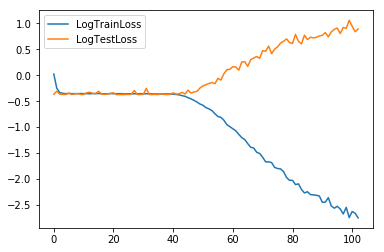

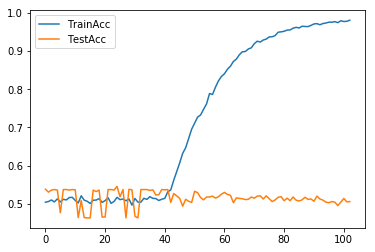

In [8]:
# TRAIN MODEL

if __name__ == "__main__":
    
    ## Save Tokenizer ##
    
    with open(os.path.join('..', 'models', 'toke.pkl'), 'wb') as toke_file:
        pickle.dump(toke, toke_file, protocol=pickle.HIGHEST_PROTOCOL)
        
    ## Create Model ##
    
    model = get_model(emb_matrix)
    
    e_stopping = EarlyStopping(monitor='val_loss', patience=80)
    checkpoint = ModelCheckpoint(os.path.join('..', 'models', 'media-headlines.h5'), 
                                 monitor='val_loss',
                                 verbose=0,
                                 save_best_only=True)
    
    ## Train ##
    
    history = model.fit([trainX, trainX2],
                        trainY,
                        epochs=epochs, 
                        batch_size=batch_size,
                        validation_data=([testX, testX2], testY),
                        verbose=0,
                        callbacks=[e_stopping, checkpoint])
    
    ## Display Train Data ##
    
    plt.plot(np.log(history.history['loss']))
    plt.plot(np.log(history.history['val_loss']))
    plt.legend(['LogTrainLoss', 'LogTestLoss'])
    plt.show()
    
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.legend(['TrainAcc', 'TestAcc'])
    plt.show()
    

In [9]:
# TEST MODEL

if __name__ == "__main__":
    
    ## Load Model For Manual Testing ##
    
    with open(os.path.join('..', 'models', 'toke.pkl'), 'rb') as toke_file:
        toke = pickle.load(toke_file)
    
    model = load_model(os.path.join('..', 'models', 'media-headlines.h5'))
    
    ## Fake Unique Test Data ##
    
    test_sents = [
        'the ceo of **COMPANY** was fired after selling a bad **PRODUCT**', 
        '**COMPANY** just released a **PRODUCT** thats better than every other company',
        '**COMPANY**s **PRODUCT** killed a family of ducks in a sensor malfunction',
        'the **COMPANY** team released a breakthrough in **PRODUCT** gaming'
    ]
    
    ## Process ##
    
    encoded_sources, test_encoded, _ = encode_sentences(['twitter', 'twitter', 'reddit', 'seekingalpha'], 
                                                        test_sents, 
                                                        tokenizer=toke, 
                                                        max_length=max_length, 
                                                        vocab_size=vocab_size)
    
    predictions = model.predict([test_encoded, encoded_sources])
    
    ## Display Predictions ##
    
    for i in range(len(test_sents)):
        
        print("")
        print(test_sents[i])
        print(predictions[i])
        print("Stock Will Go Up" if np.argmax(predictions[i]) == 0 else "Stock Will Go Down")



the ceo of **COMPANY** was fired after selling a bad **PRODUCT**
[ 0.5336712   0.46632883]
Stock Will Go Up

**COMPANY** just released a **PRODUCT** thats better than every other company
[ 0.53861409  0.46138591]
Stock Will Go Up

**COMPANY**s **PRODUCT** killed a family of ducks in a sensor malfunction
[ 0.53140241  0.46859762]
Stock Will Go Up

the **COMPANY** team released a breakthrough in **PRODUCT** gaming
[ 0.53838307  0.46161693]
Stock Will Go Up


In [10]:
# TEST MODEL

if __name__ == "__main__":
    
    ## **This Test May Overlap w/Train Data** ##
    
    current_date = '2018-02-06'
    predict_date = '2018-02-07'
    stock = 'AAPL'
    
    with db() as (conn, cur):
        
        ## Select Actual Stock Values ##
        
        cur.execute("""SELECT adjclose FROM ticks WHERE stock=? AND date BETWEEN ? AND ? ORDER BY date""", 
                    ['AAPL', current_date, predict_date])
        ticks = cur.fetchall()
        
        ## Find Headlines ##
    
        cur.execute("SELECT source, content FROM headlines WHERE date=? AND stock=?", [current_date, stock])
        headlines = cur.fetchall()
        
        ## Process ##
        
        sources, test_sents = [], []
        
        for (source, content) in headlines:
            
            sources.append(source)
            test_sents.append(content)
            
        encoded_sources, test_encoded, _ = encode_sentences(sources, 
                                                            test_sents, 
                                                            tokenizer=toke, 
                                                            max_length=max_length,
                                                            vocab_size=vocab_size)
        
        predictions = model.predict([test_encoded, encoded_sources])
        
        ## Display ##
        
        print("Using: " + str(test_sents))
        
        print("Predicting Change Coef: " +  str( round(np.mean(predictions[:, 0]) - .5, 2) * 2 ))
        
        print("Actual Stock Change: " + str( round(ticks[-1][0] - ticks[0][0], 2) ))
            

Using: ['nypd begins rolling out **PRODUCT** plus handsets to manhattan cops replacing windows handsets', '**COMPANY** says **PRODUCT** and x have hardware updates that address battery issues', 'rolling world stock selloff runs to trillion', 'us stocks rebound after a day of volatile trading', 'zacksjerryrig **COMPANY** heres what we do well send you a skin and you charge for the installation we split', '**COMPANY**s icloud key in takedown of notorious russian botnet operator', 'ptinews gauravcsawant sardanarohit sneheshphilip adityarajkaul sudhirchaudhary minhazmerchant', 'glucose sensor app said to be first thirdparty title to access **COMPANY** **PRODUCT**s nfc', 'homepod review roundup **COMPANY**s smart speaker sounds incredible but siri is lacking', '**COMPANY** unveils second **PRODUCT** tvos betas for developer testing', '**COMPANY** will build another datacenter in ulanqab city in north chinas inner mongolia autonomous region after its', '**COMPANY** support page discusses **P